<a href="https://colab.research.google.com/github/shashwat2820/deep-learning/blob/main/complete_style_transfer_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

from PIL import Image 
from io import BytesIO

import torch 
from torchvision import transforms , models
import requests 
import torch.optim as optim  



load the the **vgg19.features** (the cnn portion of the vgg19 model )of pretrained VGG19 model and freeze their weights 

In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained = True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
# move the model to GPU, if available
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

The **load_image()** function is a helper function defined by us to load any kind of content and style images 

In [ ]:
def load_image(img_path , max_size = 400 , shape = None):
  ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
  if "http" in img_path:
      response = requests.get(img_path)
      image  = Image.open(BytesIo(response.content)).convert('RGB')
  else:
      image = Image.open((img_path)).convert('RGB')

  if max(image.size) > max_size:
      size = max_size
  else:
      size = max(image.size) 
       
  if shape is not None:
      size = shape 

  in_transform = transforms.Compose([transforms.Resize(size) , 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485 , 0.456 , 0.406), 
                                                            (0.229 , 0.224 , 0.225))])
       
   # discard the transparent, alpha channel (that's the :3) and add the batch dimension
  image = in_transform(image)[:3 , : , :].unsqueeze(0)

  return image 
      

load the style and content image and force the style umage to be of the same size as that of the content image 

In [ ]:

content = load_image('/content/Labrador_retriever_06457.jpg').to(device)
print(content.shape)

style = load_image('/content/delaunay.jpg' , shape = content.shape[-2:]).to(device)
 #content.shape[-2:] gives the last two elments of the shape attribute i.e. height , and width , it ignore the batch_size and depth parameter

torch.Size([1, 3, 436, 400])


hepler function to unanormalize the image and convert it from tensor type to numpy type 

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229 , 0.224 , 0.225)) + np.array((0.485 , 0.456 , 0.406))
  image = image.clip(0,1) # it puts the value of pixels in the range (0,1)

  return image 


display the images 

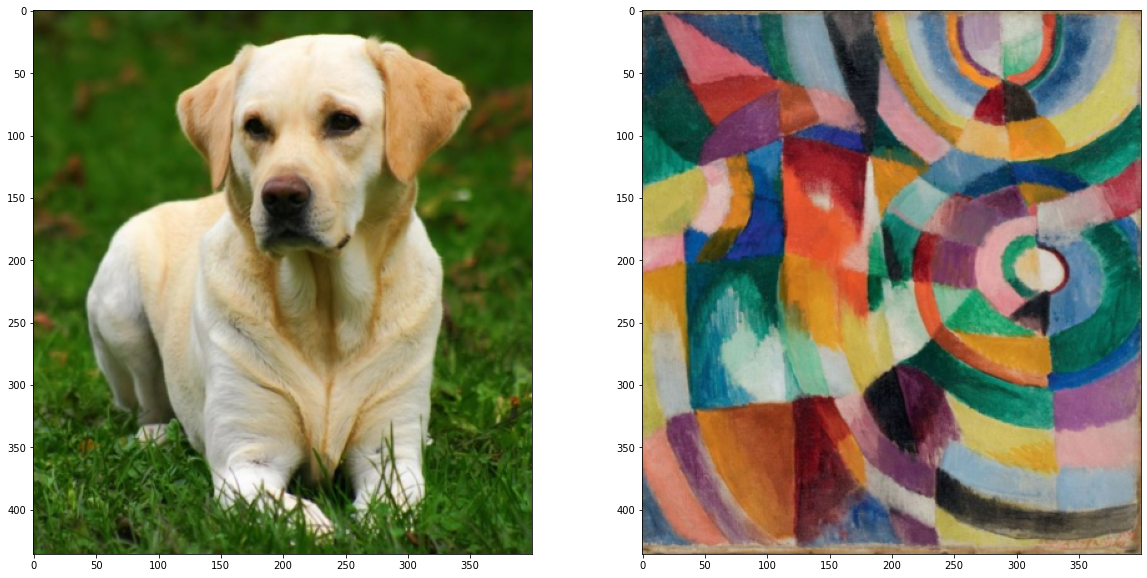

In [ ]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

feature extraction

In [ ]:
def get_features(image , model , layers = None):

  if layers is None :
    # key is the layer number and corresponding to it is the style transfer feature layers 
    layers   =    {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

  features = {}
  x = image 
  #model._modules is dictionary holding each moduke in the model 
  for name , layer in model._modules.items():
    x = layer(x) # the output of layers other than the style transfer layers 
    if name in layers:
      features[layers[name]] = x  # the output of the style transfer layers 

    
  return features 

Gram Matrix 

In [ ]:
def gram_matrix(tensor):
  #define the gram matrix of a particular tensor 

  b,d,h,w = tensor.size()

  #reshaping by multpying the features for each channel 
  tensor = tensor.view(b*d , h*w)

  #claculate the gram matrix of the tensor 
  gram = torch.mm(tensor , tensor.t()) 

  return gram 

extracting features from out image and calculating the gram matrix of each layer in our style representation 

In [ ]:
# get the content and style feature only once before training 
content_features = get_features(content , vgg)
style_features = get_features(style , vgg)

# calculate the gram matrix for each layer of our style represetation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features }

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)


Weights of the style represebation layers and the content and style weight(alpha , beta)

In [ ]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
    # the content layer conv_2 is exempted

content_weight = 1
style_weight =   1e6

Updating the Target & Calculating Losses

Total_loss 197678.859375


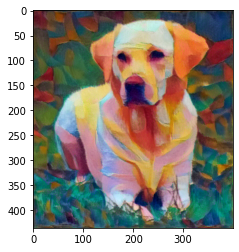

Total_loss 113475.8671875


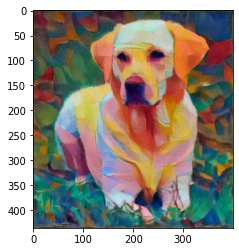

Total_loss 110417.8671875


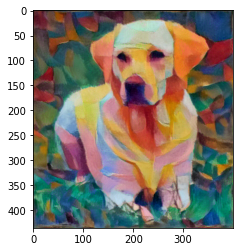

Total_loss 66387.4765625


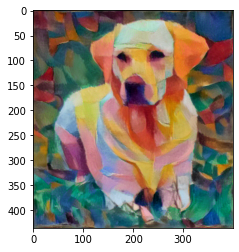

Total_loss 61332.15625


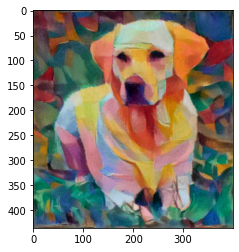

In [ ]:
show_every = 400 # the target loss will be repressented after each of the folloeing number of iteration 

#iteration hyperparameters
optimizer = optim.Adam([target] , lr = 0.03)
steps = 2000 # the number of steps to produce your target image 

for i in  range(1,steps+1):

  #get the features from your target images 
  target_features = get_features(target , vgg)

  #define the content loss 
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  # the style loss 
  # initialise the style loss to 0
  style_loss = 0
  #update the style loss with the gram matrix loss for each layer
  for layer in style_weights:
    # get the target style represenation for each layer in the style weights dictionary
    #for eample  the layer = conv1_1  
    target_feature = target_features[layer] #this will give the target feature for the layer conv1_1 for our above example
    target_gram    = gram_matrix(target_feature)#this will give the  gram matrix target feature for the layer conv1_1 for our above example
    _,d,h,w        = target_feature.shape
    # get the "style" style represenation 
    style_gram = style_grams[layer] #it stores the gram matirx for each of the following layer
    # the style loss for one layer weoghted apprpriately 
    layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
    #add to the style loss
    style_loss += layer_style_loss/(d*h*w)

  # clcualting the total loss
  total_loss   = content_weight*content_loss + style_weight*style_loss
  
  #update your target image 
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # dispaly the intermidiate images 
  if i % show_every ==0:
    print('Total_loss', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()



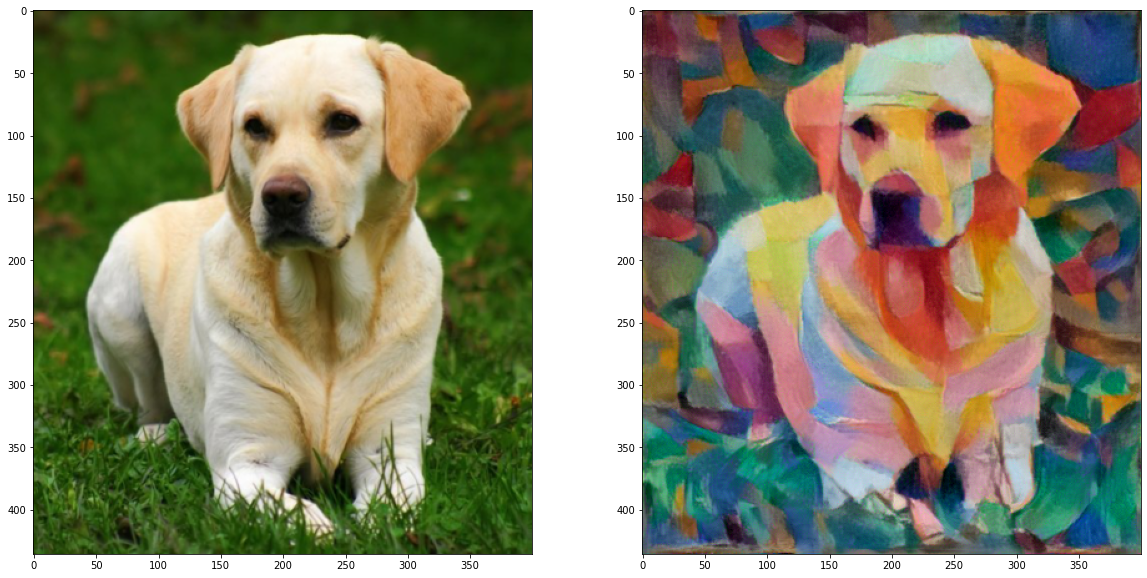

In [ ]:
# display the content and the target images respectively 
fig , (ax1 , ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))